# XGBoost + SHAP (SCIN Data Modeling)

This notebook now uses **interpretable tabular metadata features** (not embeddings) so SHAP outputs are easier to explain in conclusions.


## Problem Statement And Use Case

Goal: predict whether a selected diagnosis label is present (binary one-vs-rest) using SCIN metadata, then explain model behavior with SHAP.

Use case: produce human-readable insights (symptoms, body-part indicators, demographics) that support a thoughtful data science narrative.

## Data Understanding

Data is loaded from `data/processed/train.csv` and `data/processed/test.csv`. Outcome is derived from `label_all`; features are structured metadata columns only.

## Why This Approach

- Tabular features are directly interpretable.
- XGBoost captures non-linear interactions.
- SHAP gives global and local explanations for conclusions.


In [34]:
from __future__ import annotations

import json
from collections import Counter
from pathlib import Path

import numpy as np
import pandas as pd
import shap
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score
from xgboost import XGBClassifier

ROOT = Path.cwd()
np.random.seed(42)

def parse_labels(s: str) -> list[str]:
    if not isinstance(s, str):
        return []
    try:
        vals = json.loads(s)
        return vals if isinstance(vals, list) else []
    except Exception:
        return []


## Load Data And Define Target Label


In [37]:
train_df = pd.read_csv(ROOT / "data" / "processed" / "train.csv")
test_df = pd.read_csv(ROOT / "data" / "processed" / "test.csv")

counter = Counter()
for s in train_df["label_all"].fillna("[]"):
    counter.update(parse_labels(s))

label_counts = pd.Series(counter).sort_values(ascending=False)

# Change this if you want a specific class
DEFAULT_TARGET_LABEL = "Eczema"
target_label = DEFAULT_TARGET_LABEL if DEFAULT_TARGET_LABEL in label_counts.index else label_counts.index[0]

print(f"Train rows: {len(train_df)} | Test rows: {len(test_df)}")
print(f"Target label: {target_label}")
print(f"Top 10 labels by frequency:\n{label_counts.head(10)}")


Train rows: 2448 | Test rows: 613
Target label: Eczema
Top 10 labels by frequency:
Eczema                         847
Allergic Contact Dermatitis    690
Insect Bite                    333
Urticaria                      263
Psoriasis                      249
Folliculitis                   210
Irritant Contact Dermatitis    199
Tinea                          167
Drug Rash                      120
Herpes Simplex                 108
dtype: int64


## Build Interpretable Feature Matrix


In [38]:
feature_prefixes = [
    "age_group",
    "sex_at_birth",
    "fitzpatrick_skin_type",
    "combined_race",
    "condition_duration",
    "related_category",
    "num_images",
    "race_ethnicity_",
    "textures_",
    "body_parts_",
    "condition_symptoms_",
    "other_symptoms_",
]

def pick_features(df: pd.DataFrame) -> list[str]:
    cols = []
    for c in df.columns:
        if any(c == p or c.startswith(p) for p in feature_prefixes):
            cols.append(c)
    return sorted(set(cols))

tab_features = pick_features(train_df)

def has_label(s: str, label: str) -> int:
    return int(label in parse_labels(s))

y_train = train_df["label_all"].fillna("[]").apply(lambda s: has_label(s, target_label)).to_numpy()
y_test = test_df["label_all"].fillna("[]").apply(lambda s: has_label(s, target_label)).to_numpy()

X_train = pd.get_dummies(train_df[tab_features].fillna("UNKNOWN"), drop_first=False)
X_test = pd.get_dummies(test_df[tab_features].fillna("UNKNOWN"), drop_first=False)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

print(f"Encoded feature count: {X_train.shape[1]}")
print(f"Target prevalence (train): {y_train.mean():.4f}")
print(f"Target prevalence (test):  {y_test.mean():.4f}")


Encoded feature count: 138
Target prevalence (train): 0.3460
Target prevalence (test):  0.3409


## Train XGBoost On Tabular Features


In [39]:
tab_model = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    tree_method="hist",
    eval_metric="logloss",
    n_jobs=-1,
    verbosity=0,
)

tab_model.fit(X_train, y_train)
pred = tab_model.predict(X_test)

print("Class-specific metrics:")
print(f"Precision: {precision_score(y_test, pred, zero_division=0):.4f}")
print(f"Recall:    {recall_score(y_test, pred, zero_division=0):.4f}")
print(f"F1:        {f1_score(y_test, pred, zero_division=0):.4f}")


Class-specific metrics:
Precision: 0.5644
Recall:    0.2727
F1:        0.3677


## SHAP For Interpretable Tabular Features


In [40]:
max_samples = min(300, len(X_test))
X_subset = X_test.iloc[:max_samples].astype(np.float32)

dmatrix = xgb.DMatrix(X_subset.values, feature_names=list(X_subset.columns))
contrib = tab_model.get_booster().predict(dmatrix, pred_contribs=True)

shap_values = contrib[:, :-1]
base_values = contrib[:, -1]
feature_names = list(X_subset.columns)

print(f"X_subset shape: {X_subset.shape}")
print(f"SHAP shape: {shap_values.shape}")


X_subset shape: (300, 138)
SHAP shape: (300, 138)


/var/folders/y0/7m6nkz493vd5rdb_rb4g62gw0000gn/T/ipykernel_44661/2318983505.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset.values, feature_names=feature_names, plot_type="bar", max_display=20)


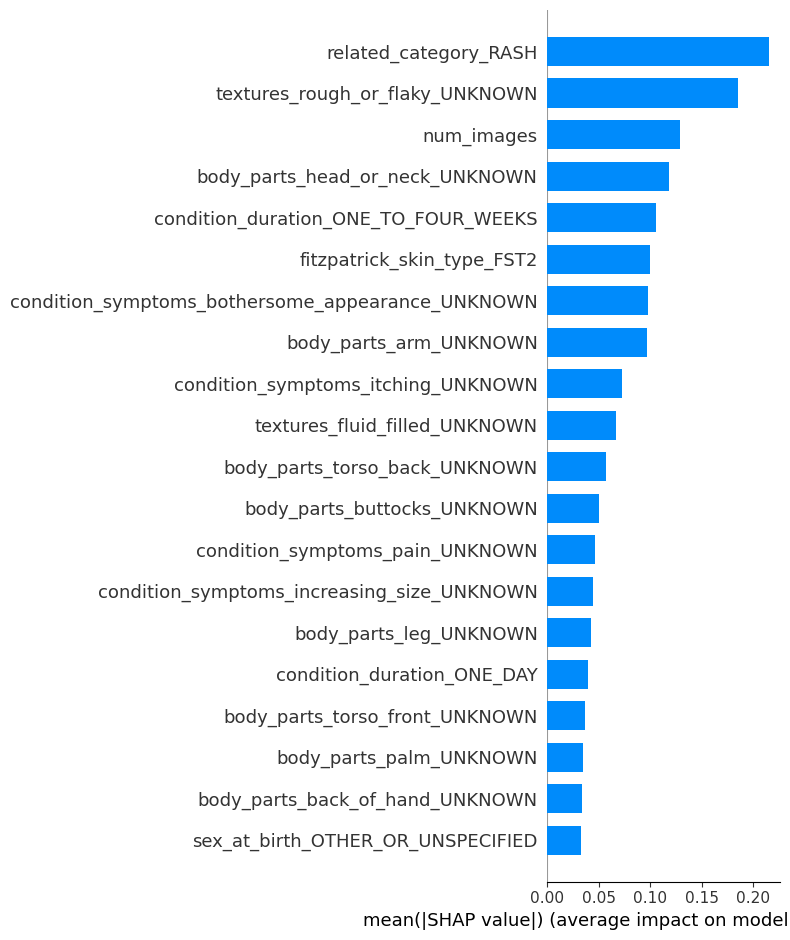

In [41]:
shap.summary_plot(shap_values, X_subset.values, feature_names=feature_names, plot_type="bar", max_display=20)


/var/folders/y0/7m6nkz493vd5rdb_rb4g62gw0000gn/T/ipykernel_44661/709249702.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_subset.values, feature_names=feature_names, max_display=20)


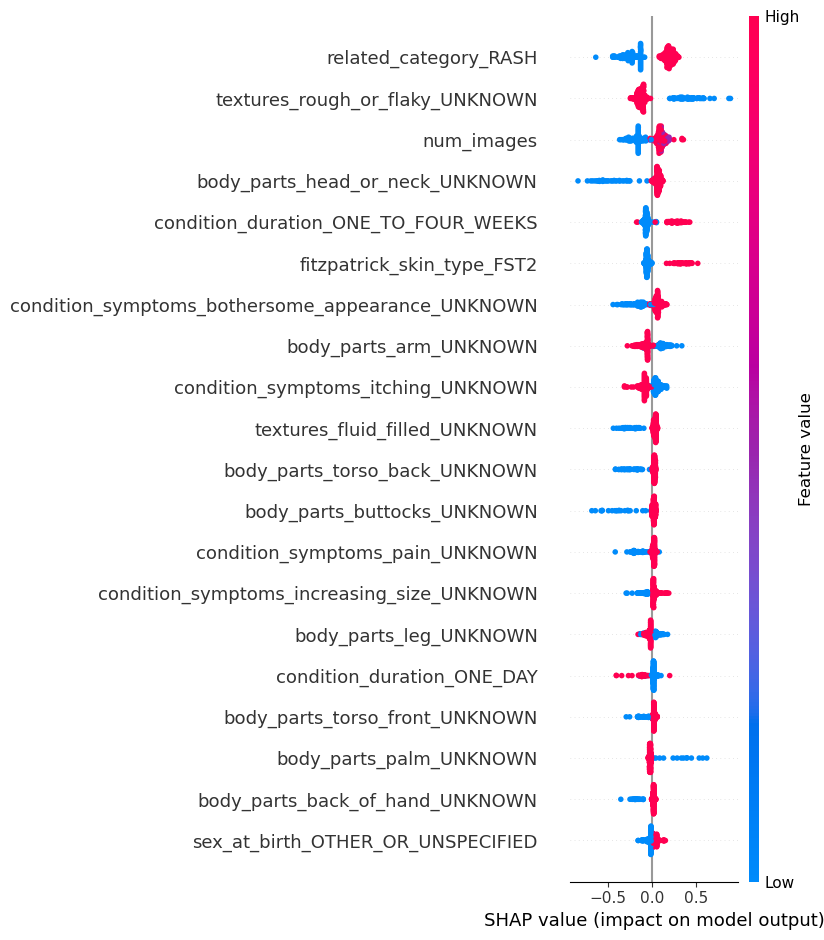

In [42]:
shap.summary_plot(shap_values, X_subset.values, feature_names=feature_names, max_display=20)


## Explain A Single Prediction


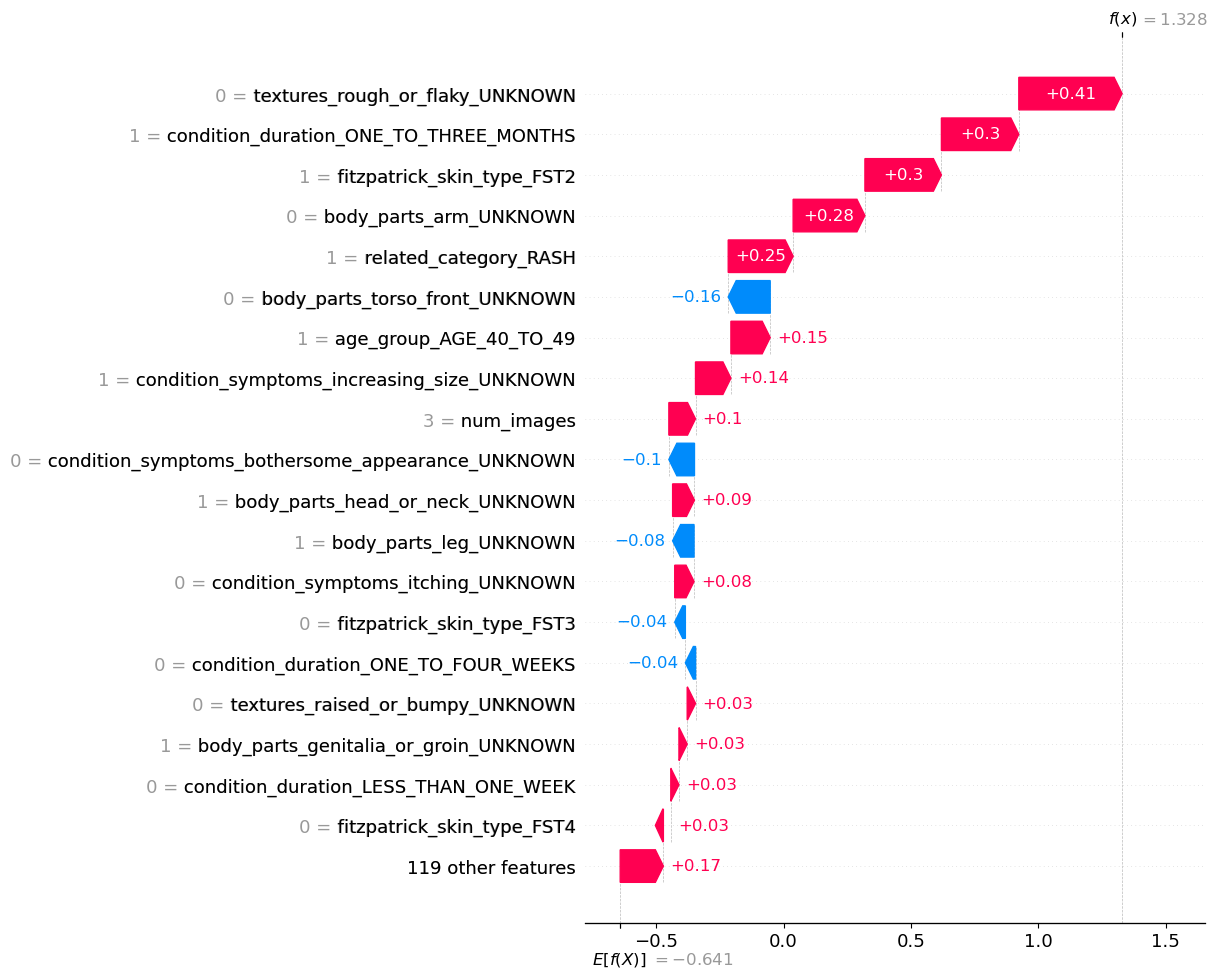

In [43]:
sample_idx = 0
sample_explanation = shap.Explanation(
    values=shap_values[sample_idx],
    base_values=float(base_values[sample_idx]),
    data=X_subset.iloc[sample_idx].to_numpy(),
    feature_names=feature_names,
)
shap.plots.waterfall(sample_explanation, max_display=20)


## Interpretation:
- This specific case is predicted as positive with high confidence: the score moves from a low baseline (E[f(X)] = -0.641) to a high final value (f(x)=1.328), so the model is strongly pushed toward the positive class.

- Main drivers are a few features: condition_duration_ONE_TO_THREE_MONTHS, fitzpatrick_skin_type_FST2, related_category_RASH, and textures_rough_or_flaky_UNKNOWN contribute most to increasing the prediction.

- Some features push down, but their negative impact is smaller than the positive pushes, so net prediction stays high.



## Causal Inference (Exploratory Add-On)

This section is optional and observational: interpret as hypothesis-generating, not causal proof.


In [44]:
# Optional: simple IPW ATE estimate on metadata
df = pd.read_csv(ROOT / "data" / "processed" / "test.csv")

treatment_col = "sex_at_birth"
treated_value = "FEMALE"

T = (df[treatment_col].fillna("UNKNOWN") == treated_value).astype(int).to_numpy()
Y = df["label_all"].fillna("[]").apply(lambda s: int(target_label in parse_labels(s))).to_numpy()

confounders = ["age_group", "fitzpatrick_skin_type", "combined_race", "condition_duration"]
Xc = pd.get_dummies(df[confounders].fillna("UNKNOWN"), drop_first=True)

ps_model = LogisticRegression(max_iter=2000)
ps_model.fit(Xc, T)
ps = np.clip(ps_model.predict_proba(Xc)[:, 1], 0.01, 0.99)

w_t = T / ps
w_c = (1 - T) / (1 - ps)
ate = (w_t * Y).sum() / w_t.sum() - (w_c * Y).sum() / w_c.sum()

print(f"Target label: {target_label}")
print(f"Treatment: {treatment_col} == {treated_value}")
print(f"Estimated IPW ATE (risk difference): {ate:.4f}")


Target label: Eczema
Treatment: sex_at_birth == FEMALE
Estimated IPW ATE (risk difference): -0.0111


## DoWhy (Common Causes + Instruments)


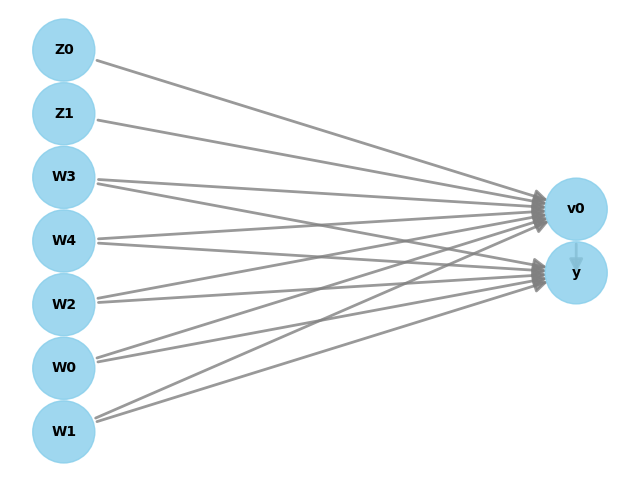

In [45]:
from dowhy import CausalModel
from dowhy.datasets import linear_dataset

data = linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=1000,
    treatment_is_binary=True,
    outcome_is_binary=False,
)

df_dw = data["df"]
model_dw = CausalModel(
    data=df_dw,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    instruments=data["instrument_names"],
)
try:
    model_dw.view_model()
except Exception as exc:
    print(f"Graph rendering skipped: {exc}")


In [46]:
identified_estimand = model_dw.identify_effect()
print(identified_estimand)

estimate = model_dw.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print(estimate)


Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W4,W3,U) = P(y|v0,W1,W0,W2,W4,W3)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
  d                       
─────(E[y|W1,W0,W2,W4,W3])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W1,W0,W2,W4,W3,U) = P(y|v0,W1,W0,W2,W4,W3)

*** Causal E

In [47]:
refute = model_dw.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(refute)


Refute: Add a random common cause
Estimated effect:6.906239422952968
New effect:6.905453961477473
p value:0.96



### DoWhy On Real Dataset (`df_dowhy_real`)


DoWhy real-data rows: 613
Outcome prevalence (Eczema): 0.3409
Treatment rate (sex_at_birth=FEMALE): 0.3524


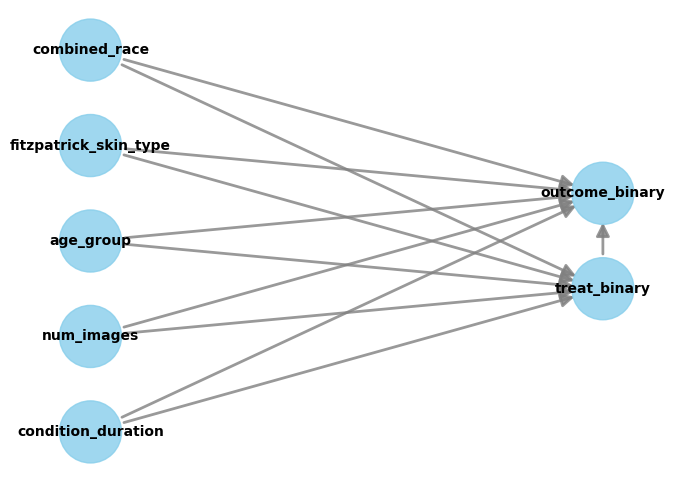

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                                                                       ↪
───────────────(E[outcome_binary|condition_duration,num_images,age_group,fitzp ↪
d[treat_binary]                                                                ↪

↪                                 
↪ atrick_skin_type,combined_race])
↪                                 
Estimand assumption 1, Unconfoundedness: If U→{treat_binary} and U→outcome_binary then P(outcome_binary|treat_binary,condition_duration,num_images,age_group,fitzpatrick_skin_type,combined_race,U) = P(outcome_binary|treat_binary,condition_duration,num_images,age_group,fitzpatrick_skin_type,combined_race)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

### Estimand : 4
Estimand name: general_adjustment
Estimand expression:
       d                       

In [48]:
df_meta = pd.read_csv(ROOT / "data" / "processed" / "test.csv").copy()

df_meta["outcome_binary"] = df_meta["label_all"].fillna("[]").apply(
    lambda s: int(target_label in parse_labels(s))
)

treatment_col = "sex_at_birth"
treated_value = "FEMALE"
df_meta["treat_binary"] = (df_meta[treatment_col].fillna("UNKNOWN") == treated_value).astype(int)

real_common_causes = [
    "age_group",
    "fitzpatrick_skin_type",
    "combined_race",
    "condition_duration",
    "num_images",
]

df_dowhy_real = df_meta[["treat_binary", "outcome_binary"] + real_common_causes].copy()
for col in real_common_causes:
    if pd.api.types.is_numeric_dtype(df_dowhy_real[col]):
        df_dowhy_real[col] = df_dowhy_real[col].fillna(df_dowhy_real[col].median())
    else:
        df_dowhy_real[col] = df_dowhy_real[col].fillna("UNKNOWN").astype("category").cat.codes

df_dowhy_real = df_dowhy_real.dropna().copy()

print(f"DoWhy real-data rows: {len(df_dowhy_real)}")
print(f"Outcome prevalence ({target_label}): {df_dowhy_real['outcome_binary'].mean():.4f}")
print(f"Treatment rate ({treatment_col}={treated_value}): {df_dowhy_real['treat_binary'].mean():.4f}")

model_real = CausalModel(
    data=df_dowhy_real,
    treatment="treat_binary",
    outcome="outcome_binary",
    common_causes=real_common_causes,
)

try:
    model_real.view_model()
except Exception as exc:
    print(f"Graph rendering skipped: {exc}")

identified_real = model_real.identify_effect(proceed_when_unidentifiable=True)
print(identified_real)

estimate_real = model_real.estimate_effect(
    identified_real,
    method_name="backdoor.linear_regression"
)
print(estimate_real)

refute_real = model_real.refute_estimate(
    identified_real,
    estimate_real,
    method_name="random_common_cause"
)
print(refute_real)




## Causal Interpretation (DoWhy DAG) intertpratatiom:

The causal graph shows that `age_group`, `fitzpatrick_skin_type`, `combined_race`, `condition_duration`, and `num_images` are common causes of both treatment (`treat_binary`) and outcome (`outcome_binary`).

This supports using backdoor adjustment for effect estimation and indicates that unadjusted treatment-outcome comparisons would be biased.

## Conclusion

This analysis combines:
- **Predictive interpretability** (XGBoost + SHAP) to explain *why* a prediction is high for a given case.
- **Assumption-transparent causal framing** (DoWhy) to justify adjustment strategy before estimating treatment effects.

Overall, the model’s decision is explainable with clinically meaningful metadata patterns, while causal conclusions should be treated as observational and assumption-dependent rather than definitive proof.
